In [1]:
%reload_ext tensorboard
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import datetime

In [2]:
# Importing the modules for collecting and building the dataset
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"
import re
import cv2
# Image processing...
from PIL import Image
from pathlib import Path


In [3]:
# Importing standard ML set - numpy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Importing keras and its deep learning tools - neural network model, layers, contraints, optimizers, callbacks and utilities
from tensorflow.keras import Sequential
import keras
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras.initializers import RandomNormal, VarianceScaling

# Importing scikit-learn tools
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [4]:
# testPath = './../fics-logoaugmentator[Final]/Test/'
# trainPath = './../fics-logoaugmentator[Final]/Train/'
testPath = './../fics-logoaugmentator[Final]/AugTest/'
trainPath = './../fics-logoaugmentator[Final]/AugTrain/'
imgSize = 100

In [5]:
def scale(im):
    return cv2.resize(im, (imgSize,imgSize))

In [6]:
# Setting up the image pool
def load_image_files(container_path):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]
    print("Total Manufacturers:",len(categories))
    count = 0
    imgs = []
    y = []
    for i, direc in enumerate(folders):
        count = 0
        for file in direc.iterdir():
            count += 1
            imgs.append(scale(np.array(Image.open(file).convert("RGB"))).flatten())
            y.append(i)
    print(len(imgs),imgs[0].shape)
    X = np.array(imgs, order='F', dtype='uint8')
    y = np.asarray(y, dtype='uint8')
    return [X,y,categories]

In [7]:
X_test,y_test,_ = load_image_files(testPath)
X_train,y_train,logos = load_image_files(trainPath)

Total Manufacturers: 19
3368 (30000,)
Total Manufacturers: 19
4329 (30000,)


In [8]:
# Some additional data preparation needs to be done before blasting the images into the neural net
X_test,y_test = shuffle(X_test, y_test, random_state=42) # 42, what else? ;)
X_train,y_train = shuffle(X_train, y_train, random_state=42) # 42, what else? ;)

(30000,) (30000,)


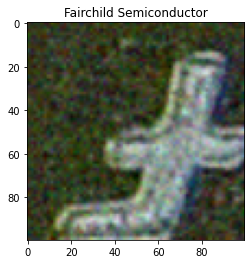

In [9]:
# Testing if the images loaded up okay - 500 should show Alfa Romeo label and a five-logo image
r = 123
print(X_train[0].shape, X_train[1].shape)
plt.imshow(X_train[r].reshape(imgSize, imgSize, 3))
plt.title(logos[y_train[r]])
plt.show()

In [10]:
# We have to prepare the dataset to fit into the CNN
# X_train, X_test, y_train, y_test = train_test_split(train_data[0], train_data[1],test_size=0.2,stratify=train_data[1])

# we will maintain a copy of the test set, as we will do a couple of transformation to it
X_test_img = X_test.copy()
y_test_img = y_test.copy()
# let's bring back the images, like above
X_train = X_train.reshape(X_train.shape[0], imgSize, imgSize, 3)
X_test = X_test.reshape(X_test.shape[0], imgSize, imgSize, 3)

# Now for some convergence-friendly procedure (is supposed to converge a lot faster when brought to 0-1 float)...
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# ...and some additional pre-processing, to zero-center the data...
X_train = np.subtract(X_train, 0.5)
X_test = np.subtract(X_test, 0.5)

# ...and to scale it to (-1, 1)
X_train = np.multiply(X_train, 2.0)
X_test = np.multiply(X_test, 2.0)

# Labels have to be transformed to categorical
Y_train = np_utils.to_categorical(y_train, num_classes=len(logos))
Y_test = np_utils.to_categorical(y_test, num_classes=len(logos))

In [11]:
# Finally for some CNN construction!
batch=8
n_classes = len(logos)
n_epochs =30
# images are RGB, so they use up 3 channels for Red, Green and Blue, respectively
n_channels = 3

In [12]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([512,1024,2048,4096]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([.1,0.3,0.5,0.7]))
HP_L_RATE = hp.HParam('l_rate', hp.Discrete([.001,.002,.005,.0001]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
HP_IS_DENSE = hp.HParam('is_deep', hp.Discrete([1, 0]))
HP_IS_DEEP = hp.HParam('is_dense', hp.Discrete([1, 0]))
METRIC_ACCURACY = 'accuracy'
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
  hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER,HP_IS_DENSE,HP_IS_DEEP,HP_L_RATE],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')])

In [13]:
def train_test_model(hparams):
    model = Sequential()
    model.add(Conv2D(32, (3,3),
                    input_shape=(imgSize,imgSize,n_channels),
                    padding='valid',
                    bias_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.00004),
                    kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3),
                    padding='valid',
                    bias_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.00004),
                    kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128, (3,3),
                    padding='valid',
                    bias_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.00004),
                    kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                    activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    if hparams[HP_IS_DEEP]==1:
        model.add(Conv2D(256, (3,3),
                        padding='valid',
                        bias_initializer='glorot_uniform',
                        kernel_regularizer=l2(0.00004),
                        kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                        activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Conv2D(512, (3,3),
                        padding='valid',
                        bias_initializer='glorot_uniform',
                        kernel_regularizer=l2(0.00004),
                        kernel_initializer=VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None),
                        activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    
    if hparams[HP_IS_DENSE]==1:
            model.add(Dense(hparams[HP_NUM_UNITS], activation='relu', bias_initializer='glorot_uniform'))
            model.add(Dropout(hparams[HP_DROPOUT]))

            model.add(Dense(hparams[HP_NUM_UNITS], activation='relu', bias_initializer='glorot_uniform'))
            model.add(Dropout(hparams[HP_DROPOUT]))
    
    model.add(Dense(len(logos), activation='softmax'))        
    
    early_stopping = EarlyStopping(patience=0, monitor='val_loss')
    # take_best_model = ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1, save_best_only=True)

    log_dir = "logs/hparam_tuning2/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    hparams_callback = hp.KerasCallback(log_dir, hparams)
    model.summary()
    if hparams[HP_OPTIMIZER]=='adam':
        opt=Adam(learning_rate=hparams[HP_L_RATE])
    else:
        opt=SGD(lr=hparams[HP_L_RATE])
    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    model.fit(X_train, Y_train, batch_size=batch, shuffle=True, epochs=n_epochs, verbose=1, validation_data=(X_test, Y_test),steps_per_epoch=X_train.shape[0]//8, workers=4,
        callbacks=[early_stopping,tensorboard_callback, hparams_callback]) 
    
    _, accuracy = model.evaluate(X_test, Y_test)
    
    return accuracy

In [14]:
def run(run_dir, hparams):
  with tf.summary.create_file_writer(run_dir).as_default():
    hp.hparams(hparams)  # record the values used in this trial
    accuracy = train_test_model(hparams)
    tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)

In [ ]:
session_num = 0
for l_rate in HP_L_RATE.domain.values:
  for optimizer in HP_OPTIMIZER.domain.values:
    for is_deep in HP_IS_DEEP.domain.values:
      for is_dense in HP_IS_DENSE.domain.values:
        if is_dense==1:
          for num_units in HP_NUM_UNITS.domain.values:
            for dropout_rate in HP_DROPOUT.domain.values:
              hparams = {
                  HP_NUM_UNITS: num_units,
                  HP_IS_DEEP: is_deep,
                  HP_L_RATE: l_rate,
                  HP_DROPOUT: dropout_rate,
                  HP_OPTIMIZER: optimizer,
                  HP_IS_DENSE: is_dense
              }
              run_name = "run-%d" % session_num
              print('--- Starting trial: %s' % run_name)
              print({h.name: hparams[h] for h in hparams})
              run('logs/hparam_tuning2/' + run_name, hparams)
              session_num += 1
        else:
          hparams = {
                HP_NUM_UNITS: 0,
                HP_IS_DEEP: is_deep,
                HP_L_RATE: l_rate,
                HP_DROPOUT: 0,
                HP_OPTIMIZER: optimizer,
                HP_IS_DENSE: 0
            }
          run_name = "run-%d" % session_num
          print('--- Starting trial: %s' % run_name)
          print({h.name: hparams[h] for h in hparams})
          run('logs/hparam_tuning2/' + run_name, hparams)
          session_num += 1

In [ ]:
def ImageConvert(n, i):
    im_ex = i.reshape(n, imgSize, imgSize, 3)
    im_ex = im_ex.astype('float32') / 255
    im_ex = np.subtract(im_ex, 0.5)
    im_ex = np.multiply(im_ex, 2.0)
    return im_ex

In [ ]:
scores = model.evaluate(X_test, Y_test) # let's look at the accuracy on the test set
print("Accuracy test: %.2f%%" % (scores[1]*100))

# Metrics of success

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as prfs

# Preparing for metrics check-up on the test set, may take a while...
Y_pred = np.argmax(model.predict(X_test), axis=-1)
print(Y_pred.shape,y_test.shape,X_test.shape)

In [ ]:
precision, recall, f1, support = prfs(y_test, Y_pred, average='weighted')
print("Precision: {:.2%}\nRecall: {:.2%}\nF1 score: {:.2%}\nAccuracy: {:.2%}".format(precision, recall, f1, scores[1]))

In [ ]:
# But let's check per class, too - assuming that larger datasets will be having higher metrics
precision_, recall_, f1_, support_ = prfs(y_test, Y_pred)
print(f1_.shape,recall_.size,f1_.size)
x = range(len(logos))
print(x)

In [ ]:
plt.subplots(figsize=(24,30))
x = range(len(logos))
plt.subplot(311)
plt.title('Precision per class')
plt.ylim(0.85, 1.00)
plt.bar(x, precision_, color='Red')
plt.xticks(x, logos, rotation = 90)
plt.subplot(312)
plt.title('Recall per class')
plt.ylim(0.85, 1.00)
plt.bar(x, recall_, color='Green')
plt.xticks(x, logos, rotation = 90)
plt.subplot(313)
plt.title('F1 score per class')
plt.ylim(0.85, 1.00)
plt.bar(x, f1_, color='Blue')
plt.xticks(x, logos, rotation = 90)
plt.show()

# Showcasing

In [ ]:
# OK, let's try the CNN in action - first defining the ShowCase() method to show everything nicely
def ShowCase(cols, rows):
    fdict = {'fontsize': 24,
            'fontweight' : 'normal',
            'verticalalignment': 'baseline'}
    plt.figure(figsize=(cols * 5, rows * 4))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35,  wspace=2)
    c = 0
    for i in range(rows * cols):
        plt.subplot(rows, cols, i + 1)
        
        # r - randomly picked from the whole dataset
        r = np.random.randint(np.shape(X_test_img)[0])
        
        # j - predicted class for the image of index r (weird syntax, but works :)
        j = int(np.argmax(model.predict(ImageConvert(1, X_test_img[r:r+1]), verbose=0), axis=-1))
        
        # increase success if predicted well
        if y_test_img[r] == j:
            c += 1
        
        # image needs reshaping back to a 50px*50px*RGB
        plt.imshow(X_test_img[r].reshape(imgSize, imgSize, 3))
        
        # plt.title will show the true brand and the predicted brand
        plt.title('True brand: '+logos[y_test_img[r]]+'\nPredicted: '+logos[j],
                  color= 'Green' if logos[y_test_img[r]] == logos[j] else 'Red', fontdict=fdict) # Green for right, Red for wrong
        
        # no ticks
        plt.xticks(())
        plt.yticks(())
        
    # print out the success rate
    print('Success rate: {}/{} ({:.2%})'.format(c, rows*cols, c/(rows*cols)))
    
    plt.show()

In [ ]:
# That is strictly for the showcasing, how the CNN works - ain't that bad, after all :)
ShowCase(10, 10)

<hr>

In [ ]:
# Setting up the image pool
new_image_path = testPath
new_imgs = os.listdir(new_image_path)
new_n_samples = np.size(new_imgs)
new_n_samples # 8

In [ ]:
# # Let's do some showcasing on-the-fly....
# cols = 3
# rows = 3
# plt.figure(figsize=(cols * 5, rows * 4))
# plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
# for i in range(new_n_samples):
#     plt.subplot(rows, cols, i + 1)
#     im = Image.open(new_image_path+new_imgs[i]).convert("RGB")
#     new_im=scale(np.array(im)).flatten()
#     # new_im = np.array(im.resize((50,50))).flatten()
#     # np.argmax(model.predict(ImageConvert(1, images[r:r+1]), verbose=0))
#     m = int(np.argmax(model.predict(ImageConvert(1, new_im), verbose=0), axis=-1))
#     plt.imshow(new_im.reshape(img_x, img_y, 3))
#     plt.title('Predicted brand: '+logos[m], size=24)
#     plt.xticks(())
#     plt.yticks(())
# plt.show()

# More analysis


In [ ]:
# let's extract the bad ones...
bad_ones = []

for i in range(len(X_test)):
    if y_test[i] != Y_pred[i]:
        bad_ones.append(i)

len(bad_ones)

In [ ]:
# ...now let's see them
samples = 10

fdict = {'fontsize': 12,
        'fontweight' : 'normal',
        'verticalalignment': 'baseline'}

for i in range(samples):
    
    # randomly choose only from the test set
    r = np.random.choice(bad_ones)
    
    # a list of probability predictions (brand classification)
    probs = model.predict_proba(X_test[r:r+1], verbose=0)[0]
    print(model.predict_proba(X_test[r:r+1], verbose=0)[0])
    # we will still need the class predicted by the model
    j = int(model.predict_classes(X_test[r:r+1], verbose=0))
    
    x = range(len(logos))
    plt.figure(figsize=(20, samples * 2))
    
    # gridspec will handle the subplots nicely - we need only a small fraction for image show, but a long one for all 40 classes
    grid = gridspec.GridSpec(samples, 2, width_ratios=[1,9])
    plt.subplot(grid[0])
    
    # here we use X_test_img - the untouched copy of X_test
    plt.imshow(X_test_img[r].reshape(imgSize, imgSize, 3))
    
    # loose the ticks in the image subplots
    plt.xticks(())
    plt.yticks(())
    plt.subplot(grid[1])
    
    # the title shows the True brand and its predicted probability and the Predicted brand (and its predicted probability, too)
    plt.title('True brand: ' + logos[y_test[r]] + " ({:.2%})".format(probs[y_test[r]]) +
              ' | Predicted: ' + logos[j] + " ({:.2%})".format(probs[j]),
              color= 'Green' if logos[y_test[r]] == logos[j] else 'Red', fontdict=fdict) # again: GreenIsGood/RedIsBad
    plt.bar(x, probs, color='DarkBlue')
    plt.xticks(x, logos, rotation = 90)
plt.show()

In [ ]:
bad_list = [0] * len(logos)
for i in y_test[bad_ones]:
    bad_list[i] += 1
plt.figure(figsize=(15,6))
plt.bar(x, bad_list, color='Gray')
plt.xticks(x, logos, rotation = 90)
plt.show()

In [ ]:
# Let's construct our own "confusion matrix" (not to be )
bD = np.zeros((len(logos),len(logos)))
for i in bad_ones:
    bD[y_test[i], Y_pred[i]] += 1

plt.figure(figsize=(8,8))
plt.imshow(bD, interpolation='bilinear', cmap='hot')
plt.xticks(x, logos, rotation=90)
plt.yticks(x, logos)
plt.title('Logo brand "confusion" matrix*')
plt.xlabel('Predicted brand', color='Red')
plt.ylabel('True brand', color='Green')
plt.figtext(1.,-.7, '* - not really a confusion matrix per se', horizontalalignment='right')
plt.show()